<a href="https://colab.research.google.com/github/priyanshujangir/ML_challenge/blob/main/IndiaT_autoenc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Input, Dense, Reshape, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import pickle
import pandas as pd
from difflib import SequenceMatcher
from concurrent.futures import ProcessPoolExecutor

In [ ]:
data = pd.read_csv('drive/MyDrive/Machine_learning/India_Today/image-search-engine/eyewear_ml_challenge.csv')
data.head()

,Unnamed: 0,product_name,product_id,parent_category,Image_Front,frame_shape
0,0,Vintage Persona C4,7641,eyeframe,http://tak-apps-dev.s3.amazonaws.com/recruitme...,Rectangle
1,1,Vintage Crazy-X C2 Red,7643,eyeframe,http://tak-apps-dev.s3.amazonaws.com/recruitme...,Rectangle
2,2,Jialedi Eyewear 1086 C8 Blue,8254,eyeframe,http://tak-apps-dev.s3.amazonaws.com/recruitme...,Rectangle
3,3,Jialedi Eyewear 1086 C6 Red,8255,eyeframe,http://tak-apps-dev.s3.amazonaws.com/recruitme...,Rectangle
4,4,Jialedi Eyewear 1086 C4 Tortoise Transperent,8256,eyeframe,http://tak-apps-dev.s3.amazonaws.com/recruitme...,Rectangle


In [ ]:
def get_image(uniq_id,name,shape,category,url):
    try:
        # Image

        # response = requests.get(url)
        # img = Image.open(BytesIO(response.content))
        # img = img.resize((250, 250), Image.ANTIALIAS)
        # img.save('flipkart/images_2/images_2/{}.jpg'.format(uniq_id))
        
        # Metadata
        img_metadata = pd.DataFrame({'id': [uniq_id],
                                     'name': [name],
                                     'shape': [shape],
                                     'category': [category]})
        
        return img_metadata
    except:
        print('fail: {}'.format(url))
        pass

In [ ]:
with ProcessPoolExecutor(max_workers = None) as executor:
    results = list(tqdm(executor.map(get_image,
                                     data.product_id.values,
                                     data.product_name.values,
                                     data.frame_shape.values,
                                     data.parent_category.values,
                                     data.Image_Front.values),
                total = len(data)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/5569 [00:00<?, ?it/s]

In [ ]:
metadata = pd.concat(results,axis=0)
metadata.to_csv('drive/MyDrive/Machine_learning/India_Today/image-search-engine/metadata.csv',index=False)

NameError: ignored

In [ ]:
img_height = 256
img_width = 256
channels = 3
batch_size = 16

train_datagen = ImageDataGenerator(#rotation_range=40,
                                   #width_shift_range=0.2,
                                   #height_shift_range=0.2,
                                   rescale=1./255,
                                   #shear_range=0.2,
                                   #zoom_range=0.2,
                                   #horizontal_flip=True,
                                   #fill_mode='nearest',
                                   validation_split=0.2)

training_set = train_datagen.flow_from_directory(
    'drive/MyDrive/Machine_learning/India_Today/images_2',
     target_size = (img_height, img_width),
     batch_size = batch_size,
     class_mode = 'input',
     subset = 'training',
     shuffle=True)

validation_set = train_datagen.flow_from_directory(
    'drive/MyDrive/Machine_learning/India_Today/images_2',
     target_size = (img_height, img_width),
     batch_size = batch_size,
     class_mode = 'input',
     subset = 'validation',
     shuffle=False)

Found 4428 images belonging to 2 classes.
Found 1106 images belonging to 2 classes.


In [ ]:
input_model = Input(shape=(img_height, img_width, channels))

# Encoder layers
encoder = Conv2D(32, (3,3), padding='same', kernel_initializer='normal')(input_model)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder = Conv2D(64, (3,3), padding='same', kernel_initializer='normal')(encoder)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder = Conv2D(64, (3,3), padding='same', kernel_initializer='normal')(input_model)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder_dim = K.int_shape(encoder)
encoder = Flatten()(encoder)

# Latent Space
latent_space = Dense(16, name='latent_space')(encoder)

# Decoder Layers
decoder = Dense(np.prod(encoder_dim[1:]))(latent_space)
decoder = Reshape((encoder_dim[1], encoder_dim[2], encoder_dim[3]))(decoder)

decoder = Conv2DTranspose(64, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(64, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(32, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(3, (3, 3), padding="same")(decoder)
output = Activation('sigmoid', name='decoder')(decoder)

# Create model object
autoencoder = Model(input_model, output, name='autoencoder')

# Model Summary
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256, 256, 64)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
flatten (Flatten)            (None, 4194304)           0         
_________________________________________________________________
latent_space (Dense)         (None, 16)                67108880  
_________________________________________________________________
dense (Dense)                (None, 4194304)           

In [ ]:
autoencoder.compile(loss="mse", optimizer= Adam(learning_rate=1e-2))

# Fit the model
history = autoencoder.fit_generator(
          training_set,
          steps_per_epoch=training_set.n // batch_size,
          epochs=4,
          validation_data=validation_set,
          validation_steps=validation_set.n // batch_size,
          callbacks = [ModelCheckpoint('drive/MyDrive/Machine_learning/India_Today/image-search-engines/models/image_autoencoder_2.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False)])


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/4
276/276 [==============================] - 359s 1s/step - loss: 0.0268 - val_loss: 0.0353
Epoch 2/4
276/276 [==============================] - 358s 1s/step - loss: 0.0234 - val_loss: 0.0378
Epoch 3/4
276/276 [==============================] - 359s 1s/step - loss: 0.0220 - val_loss: 0.0333
Epoch 4/4
276/276 [==============================] - 357s 1s/step - loss: 0.0206 - val_loss: 0.0327


In [ ]:
autoencoder = load_model('drive/MyDrive/Machine_learning/India_Today/image-search-engines/models/image_autoencoder_2.h5', compile=False)

In [ ]:
def predict_image(image_dir, autoencoder):
  raw_image = load_img(image_dir, target_size=(256, 256))
  image = img_to_array(raw_image)
  image = np.expand_dims(image, axis=0)
  image = image / 255.0
  pred = autoencoder.predict(image)
  pred = pred * 255.0
  pred = np.reshape(pred, (256, 256, 3))
  pred = array_to_img(pred)

  return raw_image, pred

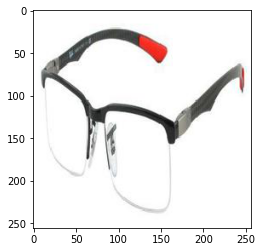

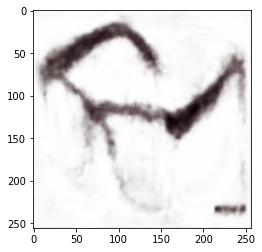

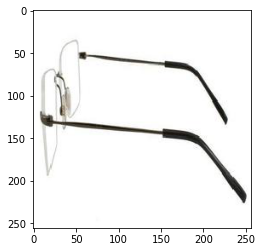

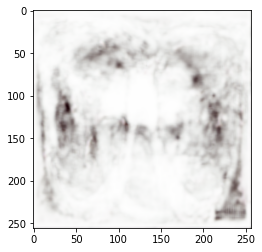

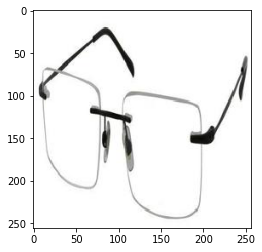

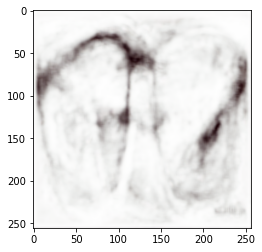

In [ ]:
train_imgs = training_set.filepaths[0:3]

for i in train_imgs:
  raw_image, pred_image = predict_image(i, autoencoder)
  
  # Show original image
  plt.imshow(raw_image)
  plt.show()
  
  # Show predicted image
  plt.imshow(pred_image)
  plt.show()

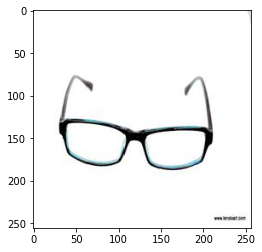

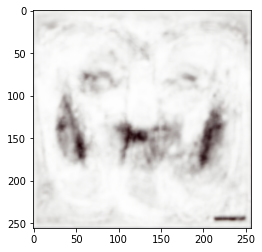

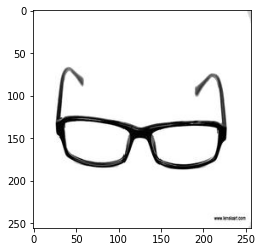

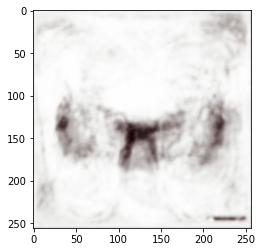

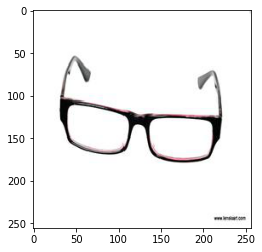

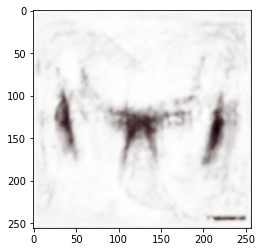

In [ ]:
val_imgs = validation_set.filepaths[0:3]

for i in val_imgs:
  raw_image, pred_image = predict_image(i, autoencoder)
  
  # Show original image
  plt.imshow(raw_image)
  plt.show()
  
  # Show predicted image
  plt.imshow(pred_image)
  plt.show()

In [ ]:
#autoencoder = load_model('models/image_autoencoder.h5', compile=False)
latent_space_model = Model(autoencoder.input, autoencoder.get_layer('latent_space').output)

In [ ]:
import os

In [ ]:
X = []
indices = []

for i in tqdm(range(len(os.listdir('drive/MyDrive/Machine_learning/India_Today/images_2/images_2')))):
  
  img_name = os.listdir('drive/MyDrive/Machine_learning/India_Today/images_2/images_2')[i]
  img = load_img('drive/MyDrive/Machine_learning/India_Today/images_2/images_2/{}'.format(img_name), target_size = (256, 256))
  img = img_to_array(img) / 255.0
  img = np.expand_dims(img, axis=0)
  pred = latent_space_model.predict(img)
  pred = np.resize(pred, (16))
  X.append(pred)
  indices.append(img_name)

  # Export the embeddings
  if i in [1,10,100,500,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,12000,13000,14000,15000,16000,17000,18000,19000]:
    embeddings = {'indices': indices, 'features': np.array(X)}

    pickle.dump(embeddings, open('drive/MyDrive/Machine_learning/India_Today/image_embeddings_2.pickle', 'wb'))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/5534 [00:00<?, ?it/s]

In [ ]:
def eucledian_distance(x,y):
  eucl_dist = np.linalg.norm(x - y)
  return eucl_dist

def category_similarity(x,y):
  return SequenceMatcher(None, x, y).ratio()

In [ ]:
embeddings = pickle.load(open('drive/MyDrive/Machine_learning/India_Today/image_embeddings_2.pickle', 'rb'))
metadata = pd.read_csv('drive/MyDrive/Machine_learning/India_Today/image-search-engine/metadata.csv')

In [ ]:
img_name = os.listdir('drive/MyDrive/Machine_learning/India_Today/images_2/images_2')[480]
img = load_img('drive/MyDrive/Machine_learning/India_Today/images_2/images_2/{}'.format(img_name), target_size=(256, 256))
img

NameError: ignored

Image Category: sunglasses


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/5001 [00:00<?, ?it/s]

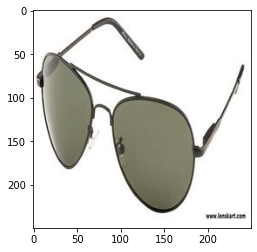

Image Category: sunglasses
Euclidean Distance: 21304.201171875


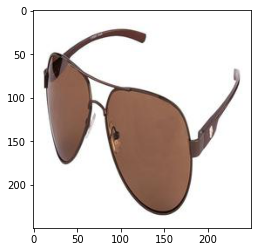

Image Category: sunglasses
Euclidean Distance: 25538.453125


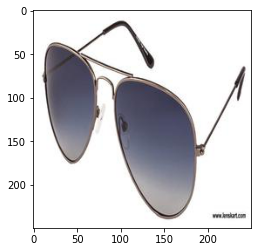

Image Category: sunglasses
Euclidean Distance: 40896.56640625


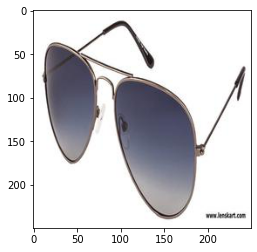

Image Category: sunglasses
Euclidean Distance: 40850.703125


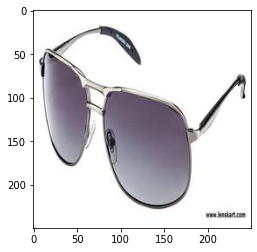

Image Category: sunglasses
Euclidean Distance: 40341.3046875


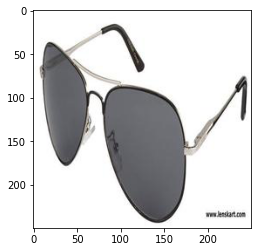

Image Category: sunglasses
Euclidean Distance: 40334.8125


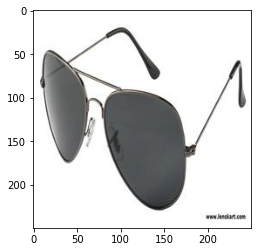

Image Category: sunglasses
Euclidean Distance: 40089.92578125


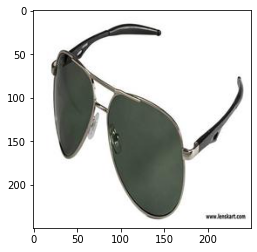

Image Category: sunglasses
Euclidean Distance: 39672.09765625


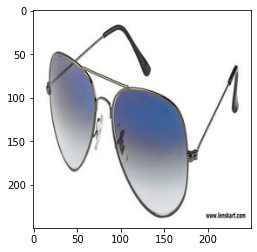

Image Category: sunglasses
Euclidean Distance: 39434.14453125


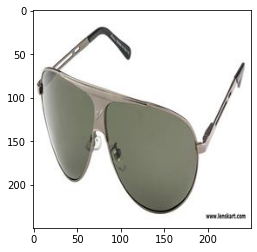

Image Category: sunglasses
Euclidean Distance: 39213.140625


In [ ]:
img_similarity = []
cat_similarity = []

# Get actual image embedding
img = img_to_array(img) / 255.0
img = np.expand_dims(img, axis=0)
pred = latent_space_model.predict(img)
pred = np.resize(pred, (16))
img_cat = metadata.query("id == '{}'".format(img_name.replace('.jpg','')))['category'].values[0]
print('Image Category: {}'.format(img_cat))

for i in tqdm(range(len(embeddings['indices']))):
  img_name = embeddings['indices'][i]

  # Calculate vectors distances
  dist = eucledian_distance(pred,embeddings['features'][i])
  img_similarity.append(dist)

  # Calculate category similarity
  cat = metadata.query("id == '{}'".format(img_name.replace('.jpg','')))['category'].values[0]
  cat_sim = category_similarity(img_cat, cat)
  cat_similarity.append(cat_sim)

imgs_result = pd.DataFrame({'img': embeddings['indices'],
                            'euclidean_distance': img_similarity,
                            'category_similarity': cat_similarity})


imgs_result = imgs_result.query('euclidean_distance > 0').sort_values(by='euclidean_distance', ascending=True).reset_index(drop=True)
imgs_result = imgs_result.iloc[0:20,:].sort_values(by='category_similarity', ascending=False).reset_index(drop=True)

# Shows the 10 first similar images
for i in range(10):
  image = load_img('drive/MyDrive/Machine_learning/India_Today/images_2/images_2/{}'.format(imgs_result['img'].values[i]))
  category = metadata.query("id == '{}'".format(imgs_result['img'].values[i].replace('.jpg','')))['category'].values[0]
  
  # Show image
  plt.imshow(image)
  plt.show()
  print('Image Category: {}'.format(category))
  print('Euclidean Distance: {}'.format(imgs_result['euclidean_distance'].values[i]))